In [2]:
using Images
using PyPlot
using Clustering
using MultivariateStats
using Printf
using Random

include("Common.jl")

Main.Common

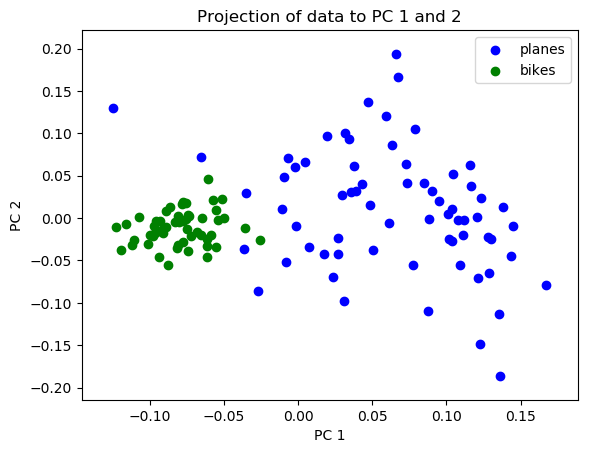

In [3]:
#---------------------------------------------------------
# Type aliases for arrays of images/features
#---------------------------------------------------------
const ImageList = Array{Array{Float64,2},1}
const FeatureList = Array{Array{Float64,2},1}


#---------------------------------------------------------
# Structure for storing datasets
#
# Fields:
#   images      images associated with this dataset
#   labels      corresponding labels
#   n           number of examples
#---------------------------------------------------------
struct Dataset
  images::Array{Array{Float64,2},1}
  labels::Array{Float64,1}
  n::Int
end

#---------------------------------------------------------
# Provides Dataset.length() method.
#---------------------------------------------------------
import Base.length
function length(x::Dataset)
  @assert length(x.images) == length(x.labels) == x.n "The length of the dataset is inconsistent."
  return x.n
end


#---------------------------------------------------------
# Structure for storing SIFT parameters.
#
# Fields:
#   fsize         filter size
#   sigma         standard deviation for filtering
#   threshold     SIFT threshold
#   boundary      number of boundary pixels to ignore
#---------------------------------------------------------
struct Parameters
  fsize::Int
  sigma::Float64
  threshold::Float64
  boundary::Int
end


#---------------------------------------------------------
# Helper: Concatenates two datasets.
#---------------------------------------------------------
function concat(d1::Dataset, d2::Dataset)
  return Dataset([d1.images; d2.images], [d1.labels; d2.labels], d1.n + d2.n)
end


#---------------------------------------------------------
# Helper: Create a train/test split of a dataset.
#---------------------------------------------------------
function traintestsplit(d::Dataset, p::Float64)
  ntrain = Int(floor(d.n * p))
  ntest = d.n - ntrain
  permuted_idx = randperm(d.n)

  train = Dataset(d.images[permuted_idx[1:ntrain]], d.labels[permuted_idx[1:ntrain]], ntrain)
  test = Dataset(d.images[permuted_idx[1+ntrain:end]], d.labels[permuted_idx[1+ntrain:end]], ntest)

  return train,test
end


#---------------------------------------------------------
# Create input data by separating planes and bikes randomly
# into two equally sized sets.
#
# Note: Use the Dataset type from above.
#
# OUTPUTS:
#   trainingset      Dataset of length 120, contraining bike and plane images
#   testingset       Dataset of length 120, contraining bike and plane images
#
#---------------------------------------------------------
function loadimages()

  nbikes = 106 # number of planes
  nplanes = 134 # number of bikes

  implanes = ImageList(undef, nplanes)
  for i = 1:nplanes
    implanes[i] = PyPlot.imread(@sprintf("planes/%03i.png",i))
  end

  imbikes = ImageList(undef, nbikes)
  for i = 1:nbikes
    imbikes[i] = PyPlot.imread(@sprintf("bikes/%03i.png",i))
  end

  # set targets to 1 and 0
  planes = Dataset(implanes, ones(Float64, nplanes), nplanes)
  bikes = Dataset(imbikes, zeros(Float64, nbikes), nbikes)

  trainplanes, testplanes = traintestsplit(planes, 0.5)
  trainbikes, testbikes = traintestsplit(bikes, 0.5)

  trainingset = concat(trainbikes, trainplanes)
  testingset = concat(testbikes, testplanes)

  @assert length(trainingset) == 120
  @assert length(testingset) == 120
  return trainingset::Dataset, testingset::Dataset

end


#---------------------------------------------------------
# Extract SIFT features for all images
# For each image in the images::ImageList, first find interest points by applying the Harris corner detector.
# Then extract SIFT to compute the features at these points.
# Use params.sigma for the Harris corner detector and SIFT together.
#---------------------------------------------------------
function extractfeatures(images::ImageList, params::Parameters)
  features = FeatureList(undef, length(images))
  for i = 1:length(images)
    py, px = Common.detect_interestpoints(images[i], params.fsize, params.threshold, params.sigma, params.boundary)
    features[i] = Common.sift([px py], images[i], params.sigma)
  end

  @assert length(features) == length(images)
  for i = 1:length(features)
    @assert size(features[i],1) == 128
  end
  return features::FeatureList
end


#---------------------------------------------------------
# Build a concatenated feature matrix from all given features
#---------------------------------------------------------
function concatenatefeatures(features::FeatureList)
  X = cat(dims=2,features...)
  @assert size(X,1) == 128
  return X::Array{Float64,2}
end

#---------------------------------------------------------
# Build a codebook for a given feature matrix by k-means clustering with K clusters
#---------------------------------------------------------
function computecodebook(X::Array{Float64,2},K::Int)
  clusterresult = kmeans(X,K)
  codebook = clusterresult.centers
  @assert size(codebook) == (size(X,1),K)
  return codebook::Array{Float64,2}
end


#---------------------------------------------------------
# Compute a histogram over the codebook for all given features
#---------------------------------------------------------
function computehistogram(features::FeatureList,codebook::Array{Float64,2},K::Int)
  N = length(features)
  H = zeros(K,N)
  for i = 1:N
    F = features[i]
    # Squared Euclidean distance matrix
    D = (sum(F.^2,dims=1) .+ sum(codebook.^2,dims=1)')' - 2*F'*codebook
    # Using the distance matrix, find assignments of features to code words
    _, minidx = findmin(D,dims=2)
    idx = zeros(Integer, size(minidx,1))
    for i = 1:length(minidx)
      tmp = CartesianIndex(minidx[i][2])
      idx[i] = tmp
    end

    # add histogram contributions
    H[:,i] = [count(x->x==k, idx) for k=1:K]
  end
  # Normalize histogram s.t. the code word distribution for each image sums up to 1
  H = broadcast(/ , H, sum(H,dims=1))

  @assert size(H) == (K,length(features))
  return H::Array{Float64,2}
end


#---------------------------------------------------------
# Visualize a feature matrix by projection to the first
# two principal components. Points get colored according to class labels y.
#---------------------------------------------------------
function visualizefeatures(X::Array{Float64,2}, y)
  # principal component analysis
  pca = fit(PCA, X)
  Xt = transform(pca, X)

  # Plot airplanes
  figure()
  idx = (y .== 1)
  scatter(Xt[1,idx], Xt[2,idx], color="blue")

  # Plot bikes
  idx = (y .== 0)
  scatter(Xt[1,idx], Xt[2,idx], color="green")

  # meta
  title("Projection of data to PC 1 and 2")
  xlabel("PC 1")
  ylabel("PC 2")
  legend(["planes", "bikes"])
  return nothing::Nothing
end


# Problem 1: Bag of Words Model: Codebook

function problem1()
  # make results reproducable
  Random.seed!(0)

  # parameters
  params = Parameters(15, 1.4, 1e-7, 10)
  K = 50

  # load trainging and testing data
  traininginputs,testinginputs = loadimages()

  # extract features from images
  trainingfeatures = extractfeatures(traininginputs.images, params)
  testingfeatures = extractfeatures(testinginputs.images, params)

  # construct feature matrix from the training features
  X = concatenatefeatures(trainingfeatures)

  # write codebook
  codebook = computecodebook(X,K)

  # compute histogram
  traininghistogram = computehistogram(trainingfeatures,codebook,K)
  testinghistogram = computehistogram(testingfeatures,codebook,K)

  # # visualize training features
  visualizefeatures(traininghistogram, traininginputs.labels)

  return nothing::Nothing
end

problem1()